# Intro

This notebook is to calcuate ATLN and ENSO indices and get a list of years for the phase of each on the CESM LENS2 project

# Imports

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import xeofs as xe
import glob
from geocat.viz import util as gvutil
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Useful functions

In [84]:
def ds_map(ds_to_plt, bounds=[1, 360, 90, -90], name='figure'):
    fig, ax = plt.subplots(1, 1,
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.longitude)

    ax.set_title(name)
    lat_ticks = np.arange(bounds[0], bounds[1], 20)
    lon_ticks = np.arange(bounds[2], bounds[3], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)

    def resize_colobar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
    # ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.latitude, cdat,
                              # levels=np.arange(-0.5, 0.5, 0.05),
                              levels=20,
                              transform=ccrs.PlateCarree(), cmap='inferno')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    resize_colobar(None)
    plt.savefig(name, dpi=300)
    plt.show()


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

# Start PBSCluster

In [217]:
# Create a PBS cluster object
cluster = PBSCluster(account='P93300313',
                     job_name='ATLN-ENSO-CESMLE2',
                     cores=1,
                     memory='8GiB',
                     processes=1,
                     walltime='02:00:00',
                     queue='casper',
                     interface='ext',
                     n_workers=1)

# dont scale unless using LE
# cluster.scale(10)

client = Client(cluster)
client

/glade/u/home/acruz/.conda/envs/EOFa_2025/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37337 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/37337/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/37337/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.173:35415,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/37337/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [218]:
cluster.scale(2)

In [219]:
# client.shutdown()
cluster.workers

{'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>}

# Data Imports

In [86]:
# files = glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/SST/*.nc')
# start with hadisst files
ds = xr.open_dataset('/glade/campaign/collections/rda/data/d277003/HadISST_sst.nc.gz').compute()

# select data

In [100]:
dates = xr.date_range(start='1970-01-16', end='2022-01-16', freq='1ME')
ds = ds.sel(time=dates, method='nearest')
ds

<xarray.Dataset> Size: 162MB
Dimensions:    (time: 624, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 5kB 1970-01-16T12:00:00 ... 2021-12-16T1...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 5kB 3.652e+04 3.656e+04 ... 5.552e+04
    sst        (time, latitude, longitude) float32 162MB -1e+03 -1e+03 ... nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    3/3/2025 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

In [88]:
ATL_hadisst = ds['sst'].sel(latitude=slice(10, -10), longitude=slice(-60, 20)).compute()
ENSO34_hadisst = ds['sst'].sel(latitude=slice(5, -5), longitude=slice(-170, -120)).compute()

In [115]:
ATL_hadisst

<xarray.DataArray 'sst' (time: 624, latitude: 20, longitude: 80)> Size: 4MB
array([[[27.28309 , 27.448025, 27.59332 , ...,       nan,       nan,
               nan],
        [27.214592, 27.393044, 27.535324, ...,       nan,       nan,
               nan],
        [      nan, 27.374252, 27.576334, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[27.076038, 27.269459, 27.43912 , ...,       nan,       nan,
               nan],
        [26.982433, 27.163929, 27.326103, ...,       nan,       nan,
               nan],
        [      nan, 27.117758, 27.28781 , ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[28.031708, 28.177385, 28.22565 , ...,       nan,       nan,
               nan],
        [27.99748 , 28.157661, 28.199469, ...,       nan,       nan,
               nan],
        [      nan, 28.140787, 28.174889, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 5kB 1970-01-16T12:00:00 ... 2021-12-16T1...
  * latitude   (latitude) float32 80B 9.5 8.5 7.5 6.5 ... -6.5 -7.5 -8.5 -9.5
  * longitude  (longitude) float32 320B -59.5 -58.5 -57.5 ... 17.5 18.5 19.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

# ATL and Niño3.4 indices

## Niño3.4 Index

In [89]:
# get weighted latitudes
weights = np.cos(np.deg2rad(ENSO34_hadisst.latitude))
weights.name = "weights"

In [90]:
ENSO34_clim = ENSO34_hadisst.mean(dim='time').compute()
ENSO34_anom = ENSO34_hadisst - ENSO34_clim
# all anomaly fields were linearly detrended zhang et al
ENSO34_anom_dtrend = detrend_dim(ENSO34_anom, dim='time')

In [91]:
ENSO34_roll = ENSO34_anom_dtrend.rolling(time=3, center=True).mean()
ENSO34_index = ENSO34_roll.mean(('longitude', 'latitude'), skipna=True).compute()

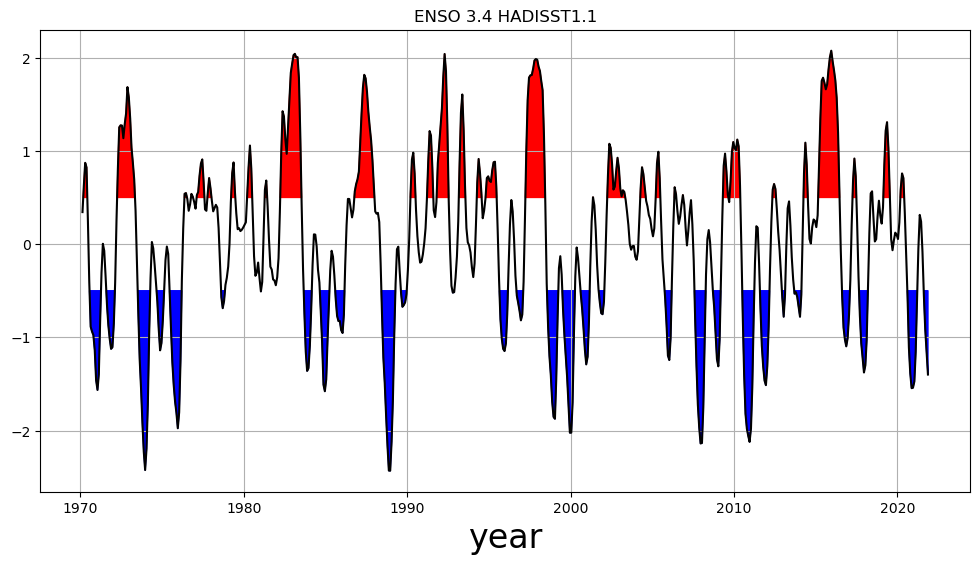

In [92]:
# index plot
fig, ax = plt.subplots(figsize=(12,6))

threshold = 0.5

ax.plot(ENSO34_index.time, ENSO34_index, color='black')
# gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

# gvutil.set_axes_limits_and_ticks(ax,ylim=(-2., 2.))
ax.fill_between(ENSO34_index.time, ENSO34_index,
                y2=-threshold, where=ENSO34_index < -threshold,
                color='blue', interpolate=True)
ax.fill_between(ENSO34_index.time, ENSO34_index,
                y2=threshold, where=ENSO34_index > threshold,
                color='red', interpolate=True)

plt.title('ENSO 3.4 HADISST1.1')
ax.set_xlabel('year', fontsize=24)
plt.grid()
plt.show()

## CANI and EANI

In [108]:
# # get weighted latitudes
# weights = np.cos(np.deg2rad(ATL_hadisst.latitude))
# weights.name = "weights"
# not necessary to weight on mean through time
ATL_clim = ATL_hadisst.mean(dim='time').compute()
ATL_anom = ATL_hadisst - ATL_clim
# all anomaly fields were linearly detrended
ATL_anom_dtrend = detrend_dim(ATL_anom, dim='time')

### EOFa

In [109]:
model = xe.single.EOF(n_modes=3, standardize=True, use_coslat=True)
model.fit(ATL_anom_dtrend, dim='time')

In [110]:
components = model.components()
components['mode'].values

array([1, 2, 3])

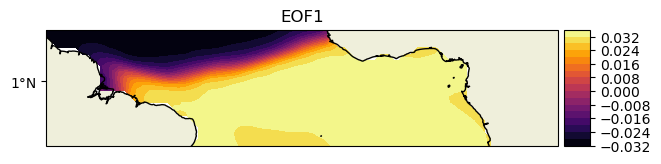

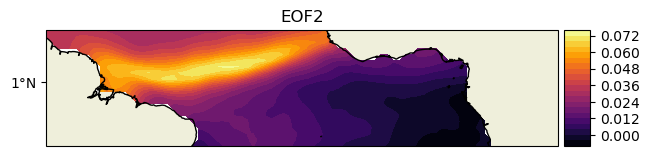

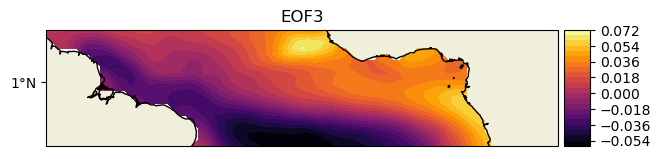

In [111]:
for i in components['mode'].values:
    mode = components.sel(mode=i)
    ds_map(mode, name=f'EOF{i}')

In [112]:
model.explained_variance_ratio()

<xarray.DataArray 'explained_variance_ratio' (mode: 3)> Size: 24B
array([0.71769095, 0.16007907, 0.05446502])
Coordinates:
  * mode     (mode) int64 24B 1 2 3
Attributes: (12/15)
    model:          EOF analysis
    software:       xeofs
    version:        3.0.4
    date:           2025-05-30 14:57:20
    n_modes:        3
    center:         True
    ...             ...
    sample_name:    sample
    feature_name:   feature
    random_state:   None
    compute:        True
    solver:         auto
    solver_kwargs:  {}

### Atlantic anomalies test plot

In [113]:
ATL_roll = ATL_anom_dtrend.rolling(time=3, center=True).mean()
ATL_anom_roll = ATL_roll.mean(('longitude', 'latitude'), skipna=True).compute()

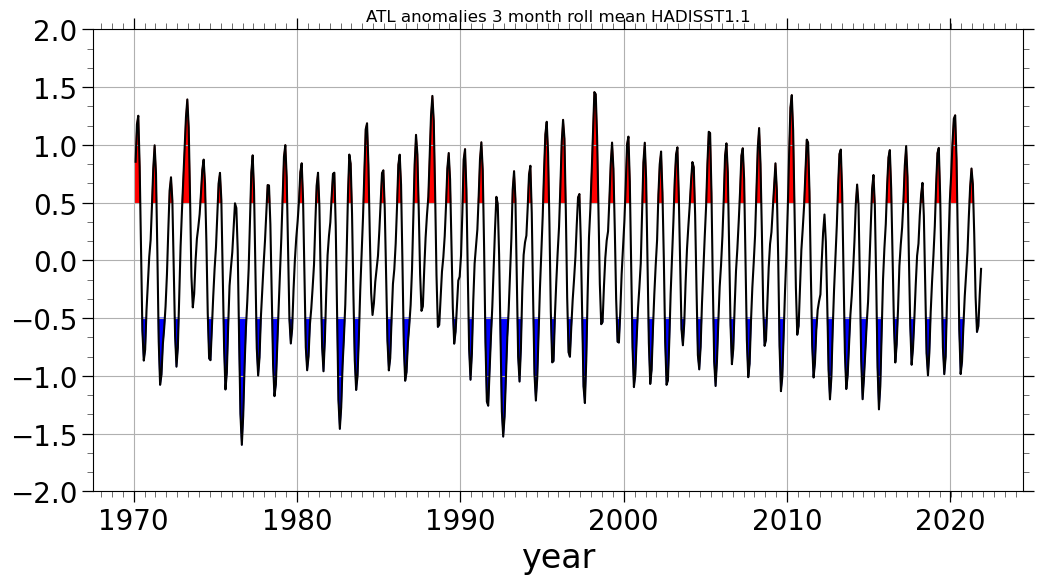

In [114]:
# index plot
fig, ax = plt.subplots(figsize=(12, 6))

threshold = 0.5

ax.plot(ATL_anom_roll.time, ATL_anom_roll, color='black')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax, ylim=(-2., 2.))
ax.fill_between(ATL_anom_roll.time, ATL_anom_roll, y2=-threshold,
                where=ATL_anom_roll < -threshold, color='blue', interpolate=True)
ax.fill_between(ATL_anom_roll.time, ATL_anom_roll, y2=threshold,
                where=ATL_anom_roll > threshold, color='red', interpolate=True)

plt.title('ATL anomalies 3 month roll mean HADISST1.1')
ax.set_xlabel('year', fontsize=24)
plt.grid()
plt.show()